# Modeling Demand for Analysis

**Target variable**: `Proj_TRN_RoomsPickup`: How many transient rooms will be booked for each stay date, from this point (8/1/17) forward, at current prices?

In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt
from agg import prep_demand_features
from demand_features import rf_cols

pd.options.display.max_rows = 162
pd.options.display.max_columns = 250
pd.options.display.max_colwidth = None

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

DATE_FMT = "%Y-%m-%d"
as_of_date = "2017-05-01"

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
date_cols = ['StayDate',
 'STLY_StayDate',
 'AsOfDate',
 'STLY_AsOfDate',
 'AsOfDate_STLY',
 'StayDate_STLY']

h1_stats = pd.read_csv("../data/h1_stats.csv", parse_dates=date_cols, infer_datetime_format=True)
h1_stats.drop(columns=["STLY_Stay_Date", "STLY_AsOfDate", "Unnamed: 0"], errors='ignore', inplace=True) # remove dup. columns


In [3]:
h1_stats.head()

,id,DOW,RoomsOTB,RevOTB,CxlForecast,TRN_RoomsOTB,TRN_RevOTB,TRN_CxlForecast,TRNP_RoomsOTB,GRP_RoomsOTB,CNT_RoomsOTB,StayDate,STLY_StayDate,DaysUntilArrival,Realized_Cxls,SellingPrice,TM30_RoomsOTB,TM30_RevOTB,TM30_TRN_RoomsOTB,TM30_TRN_RevOTB,TM15_RoomsOTB,TM15_RevOTB,TM15_TRN_RoomsOTB,TM15_TRN_RevOTB,TM05_RoomsOTB,TM05_RevOTB,TM05_TRN_RoomsOTB,TM05_TRN_RevOTB,AsOfDate,RemSupply,ADR_OTB,TRN_ADR_OTB,LYA_RoomsSold,LYA_ADR,LYA_RoomRev,LYA_NumCancels,LYA_TRN_RoomsSold,LYA_TRN_ADR,LYA_TRN_RoomRev,ACTUAL_RoomsSold,ACTUAL_ADR,ACTUAL_RoomRev,ACTUAL_TRN_RoomsSold,ACTUAL_TRN_ADR,ACTUAL_TRN_RoomRev,ACTUAL_NumCancels,ACTUAL_RoomsPickup,ACTUAL_ADR_Pickup,ACTUAL_RevPickup,ACTUAL_TRN_RoomsPickup,ACTUAL_TRN_ADR_Pickup,ACTUAL_TRN_RevPickup,MonthNum,DayOfWeek,Mon,Sat,Sun,Thu,Tue,Wed,WE,week_of_year,TM30_ADR_OTB,TM30_RoomsPickup,TM30_RevPickup,TM30_ADR_Pickup,TM30_TRN_ADR_OTB,TM30_TRN_RoomsPickup,TM30_TRN_RevPickup,TM30_TRN_ADR_Pickup,TM15_ADR_OTB,TM15_RoomsPickup,TM15_RevPickup,TM15_ADR_Pickup,TM15_TRN_ADR_OTB,TM15_TRN_RoomsPickup,TM15_TRN_RevPickup,TM15_TRN_ADR_Pickup,TM05_ADR_OTB,TM05_RoomsPickup,TM05_RevPickup,TM05_ADR_Pickup,TM05_TRN_ADR_OTB,TM05_TRN_RoomsPickup,TM05_TRN_RevPickup,TM05_TRN_ADR_Pickup,OTB_GapToLYA_RoomsSold,OTB_GapToLYA_ADR,OTB_GapToLYA_RoomRev,OTB_GapToLYA_NumCancels,OTB_GapToLYA_TRN_RoomsSold,OTB_GapToLYA_TRN_ADR,OTB_GapToLYA_TRN_RoomRev,id_STLY,AsOfDate_STLY,StayDate_STLY,RoomsOTB_STLY,ADR_OTB_STLY,RevOTB_STLY,ACTUAL_RoomsPickup_STLY,ACTUAL_ADR_Pickup_STLY,ACTUAL_RevPickup_STLY,CxlForecast_STLY,RemSupply_STLY,SellingPrice_STLY,Realized_Cxls_STLY,TRN_RoomsOTB_STLY,TRN_ADR_OTB_STLY,TRN_RevOTB_STLY,TRN_CxlForecast_STLY,ACTUAL_TRN_RoomsPickup_STLY,ACTUAL_TRN_ADR_Pickup_STLY,ACTUAL_TRN_RevPickup_STLY,TM30_RoomsPickup_STLY,TM30_ADR_Pickup_STLY,TM30_RevPickup_STLY,TM30_TRN_RoomsPickup_STLY,TM30_TRN_ADR_Pickup_STLY,TM30_TRN_RevPickup_STLY,TM15_RoomsPickup_STLY,TM15_ADR_Pickup_STLY,TM15_RevPickup_STLY,TM15_TRN_RoomsPickup_STLY,TM15_TRN_ADR_Pickup_STLY,TM15_TRN_RevPickup_STLY,TM05_RoomsPickup_STLY,TM05_ADR_Pickup_STLY,TM05_RevPickup_STLY,TM05_TRN_RoomsPickup_STLY,TM05_TRN_ADR_Pickup_STLY,TM05_TRN_RevPickup_STLY,Pace_RoomsOTB,Pace_ADR_OTB,Pace_RevOTB,Pace_CxlForecast,Pace_RemSupply,Pace_SellingPrice,Pace_TRN_RoomsOTB,Pace_TRN_ADR_OTB,Pace_TRN_RevOTB,Pace_TRN_CxlForecast,Pace_TM30_RoomsPickup,Pace_TM30_ADR_Pickup,Pace_TM30_RevPickup,Pace_TM30_TRN_RoomsPickup,Pace_TM30_TRN_ADR_Pickup,Pace_TM30_TRN_RevPickup,Pace_TM15_RoomsPickup,Pace_TM15_ADR_Pickup,Pace_TM15_RevPickup,Pace_TM15_TRN_RoomsPickup,Pace_TM15_TRN_ADR_Pickup,Pace_TM15_TRN_RevPickup,Pace_TM05_RoomsPickup,Pace_TM05_ADR_Pickup,Pace_TM05_RevPickup,Pace_TM05_TRN_RoomsPickup,Pace_TM05_TRN_ADR_Pickup,Pace_TM05_TRN_RevPickup
0,2016-07-31 - 2016-07-31,Sun,170.0,28570.36,25.0,137.0,23869.77,23.0,22.0,0.0,11.0,2016-07-31,2015-08-02,0.0,66.0,179.12,150.0,23981.92,122.0,20315.33,155.0,25254.01,127.0,21587.42,162.0,26749.13,128.0,21866.54,2016-07-31,42.0,168.06,174.23,168.0,144.92,24346.11,68.0,129.0,153.96,19860.51,170.0,168.06,28570.36,137.0,174.23,23869.77,66.0,0.0,0.00,0.00,0.0,0.00,0.00,7,Sun,False,False,1,False,False,False,False,30.0,159.88,20.0,4588.44,8.18,166.52,15.0,3554.44,7.71,162.93,15.0,3316.35,5.13,169.98,10.0,2282.35,4.25,165.12,8.0,1821.23,2.94,170.83,9.0,2003.23,3.40,-2.0,-23.14,-4224.25,2.0,-8.0,-20.27,-4009.26,2015-08-02 - 2015-08-02,2015-08-02,2015-08-02,168.0,144.92,24346.11,0.0,0.00,0.0,22.0,41.0,153.37,68.0,129.0,153.96,19860.51,21.0,0.0,0.00,0.0,7.0,4.16,1683.25,10.0,4.81,2111.23,7.0,2.54,1422.56,9.0,2.99,1743.54,6.0,1.37,1090.87,6.0,1.36,1090.87,2.0,23.14,4224.25,3.0,1.0,25.75,8.0,20.27,4009.26,2.0,13.0,4.02,2905.19,5.0,2.90,1443.21,8.0,2.59,1893.79,1.0,1.26,538.81,2.0,1.57,730.36,3.0,2.04,912.36
1,2016-07-31 - 2016-08-01,Mon,178.0,29525.52,31.0,148.0,25429.03,30.0,20.0,0.0,10.0,2016-08-01,2015-08-03,1.0,70.0,176.01,175.0,28404.00,145.0,24307.51,175.0,28536.80,145.0,24440.31,171.0,27933.34,141.0,23836.85,2016-07-31,40.0,165.87,171.82,178.0,149.32,26579.60,54.0,1

In [4]:
len(rf_cols)

40

## Splitting Up Our Data for Train/Test

For a Revenue Management application:
* Our training set will contain all dates prior to as_of_date.
* Our testing set will contain 31 stay dates starting on as_of_date. Our predictions will be used to provide price recommendations later on.

In [5]:
# method for application

mask = (h1_stats["StayDate"] < as_of_date)
test_mask = (h1_stats['AsOfDate'] >= as_of_date)
df_train = h1_stats.loc[mask].copy()
df_test = h1_stats.loc[test_mask].copy()

X_train = df_train[rf_cols].copy()
X_test = df_test[rf_cols].copy()
y_train = df_train['ACTUAL_TRN_RoomsPickup'].copy()
y_test = df_test['ACTUAL_TRN_RoomsPickup'].copy()

## Final Model

Using the params generate in demand_model_selection

In [6]:
rf = RandomForestRegressor(n_estimators=550, n_jobs=-1, random_state=20)

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7416031403142853

In [7]:
# add predictions to h1_stats for futher analysis

mask = h1_stats["AsOfDate"] >= as_of_date
h1_stat_preds = h1_stats[mask].copy()


preds = rf.predict(X_test)
h1_stat_preds["DemandPrediction"] = preds.round(0)
h1_stat_preds.index = h1_stat_preds.id

In [8]:
h1_stat_preds.head()

,id,DOW,RoomsOTB,RevOTB,CxlForecast,TRN_RoomsOTB,TRN_RevOTB,TRN_CxlForecast,TRNP_RoomsOTB,GRP_RoomsOTB,CNT_RoomsOTB,StayDate,STLY_StayDate,DaysUntilArrival,Realized_Cxls,SellingPrice,TM30_RoomsOTB,TM30_RevOTB,TM30_TRN_RoomsOTB,TM30_TRN_RevOTB,TM15_RoomsOTB,TM15_RevOTB,TM15_TRN_RoomsOTB,TM15_TRN_RevOTB,TM05_RoomsOTB,TM05_RevOTB,TM05_TRN_RoomsOTB,TM05_TRN_RevOTB,AsOfDate,RemSupply,ADR_OTB,TRN_ADR_OTB,LYA_RoomsSold,LYA_ADR,LYA_RoomRev,LYA_NumCancels,LYA_TRN_RoomsSold,LYA_TRN_ADR,LYA_TRN_RoomRev,ACTUAL_RoomsSold,ACTUAL_ADR,ACTUAL_RoomRev,ACTUAL_TRN_RoomsSold,ACTUAL_TRN_ADR,ACTUAL_TRN_RoomRev,ACTUAL_NumCancels,ACTUAL_RoomsPickup,ACTUAL_ADR_Pickup,ACTUAL_RevPickup,ACTUAL_TRN_RoomsPickup,ACTUAL_TRN_ADR_Pickup,ACTUAL_TRN_RevPickup,MonthNum,DayOfWeek,Mon,Sat,Sun,Thu,Tue,Wed,WE,week_of_year,TM30_ADR_OTB,TM30_RoomsPickup,TM30_RevPickup,TM30_ADR_Pickup,TM30_TRN_ADR_OTB,TM30_TRN_RoomsPickup,TM30_TRN_RevPickup,TM30_TRN_ADR_Pickup,TM15_ADR_OTB,TM15_RoomsPickup,TM15_RevPickup,TM15_ADR_Pickup,TM15_TRN_ADR_OTB,TM15_TRN_RoomsPickup,TM15_TRN_RevPickup,TM15_TRN_ADR_Pickup,TM05_ADR_OTB,TM05_RoomsPickup,TM05_RevPickup,TM05_ADR_Pickup,TM05_TRN_ADR_OTB,TM05_TRN_RoomsPickup,TM05_TRN_RevPickup,TM05_TRN_ADR_Pickup,OTB_GapToLYA_RoomsSold,OTB_GapToLYA_ADR,OTB_GapToLYA_RoomRev,OTB_GapToLYA_NumCancels,OTB_GapToLYA_TRN_RoomsSold,OTB_GapToLYA_TRN_ADR,OTB_GapToLYA_TRN_RoomRev,id_STLY,AsOfDate_STLY,StayDate_STLY,RoomsOTB_STLY,ADR_OTB_STLY,RevOTB_STLY,ACTUAL_RoomsPickup_STLY,ACTUAL_ADR_Pickup_STLY,ACTUAL_RevPickup_STLY,CxlForecast_STLY,RemSupply_STLY,SellingPrice_STLY,Realized_Cxls_STLY,TRN_RoomsOTB_STLY,TRN_ADR_OTB_STLY,TRN_RevOTB_STLY,TRN_CxlForecast_STLY,ACTUAL_TRN_RoomsPickup_STLY,ACTUAL_TRN_ADR_Pickup_STLY,ACTUAL_TRN_RevPickup_STLY,TM30_RoomsPickup_STLY,TM30_ADR_Pickup_STLY,TM30_RevPickup_STLY,TM30_TRN_RoomsPickup_STLY,TM30_TRN_ADR_Pickup_STLY,TM30_TRN_RevPickup_STLY,TM15_RoomsPickup_STLY,TM15_ADR_Pickup_STLY,TM15_RevPickup_STLY,TM15_TRN_RoomsPickup_STLY,TM15_TRN_ADR_Pickup_STLY,TM15_TRN_RevPickup_STLY,TM05_RoomsPickup_STLY,TM05_ADR_Pickup_STLY,TM05_RevPickup_STLY,TM05_TRN_RoomsPickup_STLY,TM05_TRN_ADR_Pickup_STLY,TM05_TRN_RevPickup_STLY,Pace_RoomsOTB,Pace_ADR_OTB,Pace_RevOTB,Pace_CxlForecast,Pace_RemSupply,Pace_SellingPrice,Pace_TRN_RoomsOTB,Pace_TRN_ADR_OTB,Pace_TRN_RevOTB,Pace_TRN_CxlForecast,Pace_TM30_RoomsPickup,Pace_TM30_ADR_Pickup,Pace_TM30_RevPickup,Pace_TM30_TRN_RoomsPickup,Pace_TM30_TRN_ADR_Pickup,Pace_TM30_TRN_RevPickup,Pace_TM15_RoomsPickup,Pace_TM15_ADR_Pickup,Pace_TM15_RevPickup,Pace_TM15_TRN_RoomsPickup,Pace_TM15_TRN_ADR_Pickup,Pace_TM15_TRN_RevPickup,Pace_TM05_RoomsPickup,Pace_TM05_ADR_Pickup,Pace_TM05_RevPickup,Pace_TM05_TRN_RoomsPickup,Pace_TM05_TRN_ADR_Pickup,Pace_TM05_TRN_RevPickup,DemandPrediction
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-01 - 2017-05-01,2017-05-01 - 2017-05-01,Mon,172.0,14581.11,7.0,106.0,9813.57,7.0,44.0,2.0,20.0,2017-05-01,2016-05-02,0.0,103.0,95.24,151.0,12394.51,76.0,6885.97,160.0,13306.69,84.0,7689.15,161.0,13534.76,95.0,8767.22,2017-05-01,22.0,84.77,92.58,180.0,70.43,12677.36,99.0,111.0,74.98,8322.38,172.0,84.77,14581.11,106.0,92.58,9813.57,103.0,0.0,0.00,0.00,0.0,0.00,0.00,5,Mon,True,False,0,False,False,False,False,18.0,82.08,21.0,2186.60,2.69,90.60,30.0,2927.60,1.98,83.17,12.0,1274.42,1.60,91.54,22.0,2124.42,1.04,84.07,11.0,1046.35,0.70,92.29,11.0,1046.35,0.29,8.0,-14.34,-1903.75,-4.0,5.0,-17.60,-1491.19,2016-05-02 - 2016-05-02,2016-05-02,2016-05-02,180.0,70.43,12677.36,0.0,0.00,0.00,21.0,28.0,73.79,99.0,111.0,74.98,8322.38,20.0,0.0,0.00,0.00,5.0,1.84,674.63,11.0,4.25,1249.23,13.0,1.90,1232.65,13.0,1.89,1159.65,6.0,-0.14,397.46,6.0,-0.50,397.46,-8.0,14.34,1903.75,-14.0,-6.0,21.45,-5.0,17.60,1491.19,-13.0,16.0,0.85,1511.97,19.0,-2.27,1678.37,-1.0,-0.30,41.77,9.0,-0.85,964.77,5.0,0.84,648.89,5.0,0.79,648.89,-1.0
2017-05-01 - 2017-05-02,2017-05-01 - 2017-05-02,Tue,153.0,11960.06,7.0,101.0

In [9]:
display_cols = [
    "DOW",
    "RemSupply",
    "RemSupply_STLY",
    "OTB_GapToLYA_TRN_RoomsSold",
    "ACTUAL_TRN_RoomsPickup",
    "DemandPrediction"
]
h1_stat_preds[display_cols].head()

,DOW,RemSupply,RemSupply_STLY,OTB_GapToLYA_TRN_RoomsSold,ACTUAL_TRN_RoomsPickup,DemandPrediction
id,,,,,,
2017-05-01 - 2017-05-01,Mon,22.0,28.0,5.0,0.0,-1.0
2017-05-01 - 2017-05-02,Tue,41.0,34.0,7.0,4.0,3.0
2017-05-01 - 2017-05-03,Wed,32.0,51.0,10.0,9.0,5.0
2017-05-01 - 2017-05-04,Thu,25.0,37.0,8.0,3.0,5.0
2017-05-01 - 2017-05-05,Fri,30.0,49.0,-4.0,4.0,7.0


In [10]:
mean_absolute_error(y_test, preds)

2.628575706646295

findfont: Font family ['Droid serif'] not found. Falling back to DejaVu Sans.


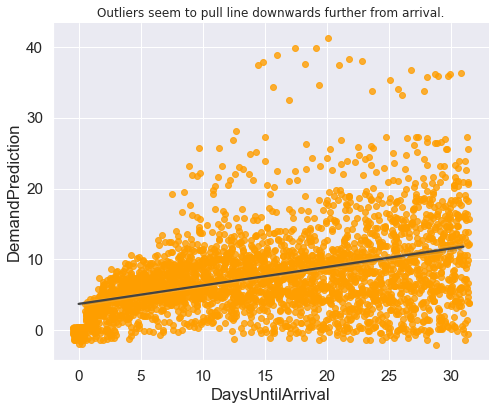

In [20]:
# plt.subplots(figsize=(7,7))
title = "Outliers seem to pull line downwards further from arrival."
# sns.set(font_scale=1.4)
ax = sns.lmplot(x="DaysUntilArrival", y="DemandPrediction", x_jitter=0.5, y_jitter=0.5, data=h1_stat_preds, height=6, aspect=1.2,
               scatter_kws={"color": "#ff9e00"}, line_kws={"color": "#434343"})

title_font = {
    "font": "Droid serif",
    "size": 12
}
plt.title(title, fontdict=title_font)
plt.tight_layout()
plt.savefig("../etc/h1_lmplot.jpeg", dpi=200)
plt.show()




## Now that we have our model, let's get it in the simulation so we can evaluate our results.

Head over to `demand_model_evaluation.ipynb` for more.